In [386]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [387]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.utils import shuffle
 

In [388]:
df = pd.read_csv("term-deposit-marketing-2020.csv")

In [389]:
RANDOM_STATE = 200

In [390]:
def plot_roc_curve(y_true, y_score):
    from sklearn.metrics import roc_curve, auc
    
    fpr, tpr, _ = roc_curve(y_true=y_true, y_score=y_score)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(9, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC (auc = {:0.2}'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

def plot_confusion_matrix(cm, class_names):
    import itertools
   
    cm = cm.astype(np.float) / cm.sum(axis=1)[:, np.newaxis]
 
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > cm.max() / 2 else "black"
        plt.text(j, i, format(cm[i, j], '.2f'), horizontalalignment="center", color=color)
        
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
   
    plt.show()

In [391]:
train = pd.read_csv('term-deposit-marketing-2020.csv')

print("Training Data")
print(train.shape)
print(train.head())

Training Data
(40000, 14)
   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign   y  
0  unknown    5   may       261         1  no  
1  unknown    5   may       151         1  no  
2  unknown    5   may        76         1  no  
3  unknown    5   may        92         1  no  
4  unknown    5   may       198         1  no  


In [392]:
df.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [393]:
df.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
39995,53,technician,married,tertiary,no,395,no,no,cellular,3,jun,107,1,no
39996,30,management,single,tertiary,no,3340,no,no,cellular,3,jun,238,3,yes
39997,54,admin,divorced,secondary,no,200,no,no,cellular,3,jun,170,1,yes
39998,34,management,married,tertiary,no,1047,no,no,cellular,3,jun,342,1,no
39999,38,technician,married,secondary,no,1442,yes,no,cellular,3,jun,113,1,no


In [394]:
df_ = df.copy()

df_["marital"] = df["marital"].map(lambda student: 1 if student == "married" else 0)
df_["default"] = df["default"].map(lambda student: 1 if student == "Yes" else 0)
df_["housing"] = df["housing"].map(lambda student: 1 if student == "Yes" else 0)
df_["loan"] = df["loan"].map(lambda student: 1 if student == "Yes" else 0)
df_["y"] = df["y"].map(lambda student: 1 if student == "Yes" else 0)


job = pd.get_dummies(df["job"], drop_first=True)
df_ = pd.concat([df_.drop("job", axis=1), job], axis=1)

education = pd.get_dummies(df["education"], drop_first=True)
df_ = pd.concat([df_.drop("education", axis=1), education], axis=1)

contact = pd.get_dummies(df["contact"], drop_first=True)
df_ = pd.concat([df_.drop("contact", axis=1), contact], axis=1)

month = pd.get_dummies(df["month"], drop_first=True)
df_ = pd.concat([df_.drop("month", axis=1), month], axis=1)



# 4
df_.head()


,age,marital,default,balance,housing,loan,day,duration,campaign,y,...,aug,dec,feb,jan,jul,jun,mar,may,nov,oct
0,58,1,0,2143,0,0,5,261,1,0,...,0,0,0,0,0,0,0,1,0,0
1,44,0,0,29,0,0,5,151,1,0,...,0,0,0,0,0,0,0,1,0,0
2,33,1,0,2,0,0,5,76,1,0,...,0,0,0,0,0,0,0,1,0,0
3,47,1,0,1506,0,0,5,92,1,0,...,0,0,0,0,0,0,0,1,0,0
4,33,0,0,1,0,0,5,198,1,0,...,0,0,0,0,0,0,0,1,0,0


In [395]:
df_["WillSubscribe"] = df["balance"].map(lambda val: 0 if val < 400 else 1)
df_.drop("balance", axis=1, inplace=True)

In [396]:
X = df_[["age", "marital", "default", "campaign", "loan", "day", "housing", "duration"]]
y = df_["WillSubscribe"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=RANDOM_STATE,stratify=y)


In [397]:
scaler = StandardScaler()
param_grid = dict(C=np.logspace(-5, 5, 11), penalty=['l2', 'l2'])
regr = LogisticRegression(random_state=RANDOM_STATE)
cv = GridSearchCV(estimator=regr, param_grid=param_grid, scoring='average_precision')
pipeline = make_pipeline(scaler, cv)

pipeline.fit(X_train, y_train)


y_true = y_test
y_pred = pipeline.predict(X_test)
y_score = pipeline.predict_proba(X_test)[:, 1]


In [398]:
estimator = LogisticRegression(random_state=RANDOM_STATE)
estimator.fit(X_train, y_train)

y_true = y_test  # 3
y_pred = estimator.predict(X_test)  # 4
y_score = estimator.predict_proba(X_test)[:, 1]  # 5

In [399]:
accuracy_score(y_true=y_true, y_pred=y_pred)


0.5381

In [400]:
confusion_matrix(y_true=y_true, y_pred=y_pred)

array([[5327, 4602],
       [4636, 5435]], dtype=int64)

In [401]:
precision_score(y_true=y_true, y_pred=y_pred)

0.5414964630865796

In [402]:
recall_score(y_true=y_true, y_pred=y_pred)

0.5396683546817596

C:\Users\krodr\AppData\Local\Temp/ipykernel_10744/3426471573.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cm = cm.astype(np.float) / cm.sum(axis=1)[:, np.newaxis]


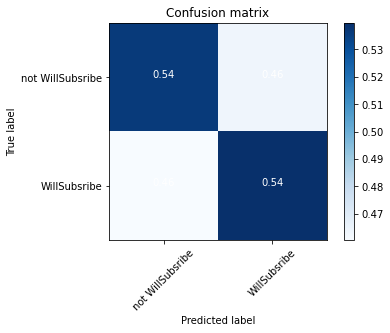

In [403]:
plot_confusion_matrix(cm=confusion_matrix(y_true=y_true, y_pred=y_pred),
                      class_names=["not WillSubsribe", "WillSubsribe"])

In [407]:
roc_auc_score(y_true=y_true, y_score=y_score)





0.551738323128869

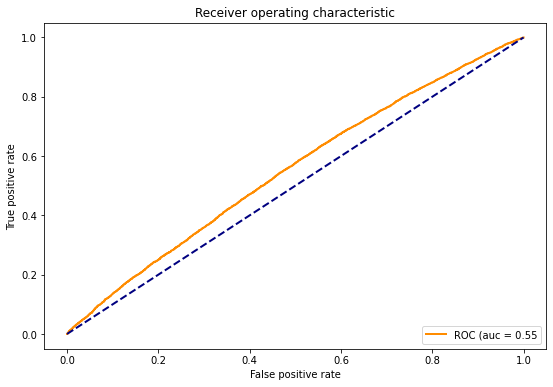

In [408]:
plot_roc_curve(y_true=y_true, y_score=y_score)

In [410]:
sns.countplot(x='y' ,data=(df), palette='hls')



NameError: name 'sns' is not defined

In [ ]:
plt.figure(figsize=(10,5))
c= df.corr()
sns.heatmap(c,cmap="BrBG",annot=True)
c


In [ ]:
#Find the category and numeric - Convert the numeric to category variables.
cat=[]
for c in train.columns:
  if train[c].dtypes == 'object':
    cat.append(c)
print(cat)

num=[]
for c in train.columns:
  if c not in cat:
    num.append(c)
print(num)


#Change the type from numeric
cat_ftrs = ['age','job', 'marital', 'default', 'housing', 'loan', 'contact', 'month', 'y']
for col in cat_ftrs:
    train[col]=train[col].astype('object')

In [ ]:
train = pd.get_dummies(train,drop_first=True)

In [ ]:
# Use a utility from sklearn to split and shuffle our dataset.
X, y = make_classification(n_samples=1000, n_classes=2, weights=[0.99, 0.01], flip_y=0, random_state=1)
train_df, test_df = train_test_split(train, test_size = 0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Response'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('self'))
test_labels = np.array(test_df.pop('self'))
#test_labels = data

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)